# Playing with histograms

I will here use the data from the stars that we downloaded two lectures ago. This consists of 500 stars in five magnitude bins.

I downloaded these using a single SQL query and saved the result in a FITS table. I first want to read in this table

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits

# Note that astropy also has a modification of hist that does the same as this one.
from astroML.plotting import hist
%matplotlib inline

In [2]:
def read_star_table():
    """
    Read in the simple star table.
    """
    hdul = fits.open('../Datafiles/UnionOfStars_jarle.fit')
    t = hdul[1].data
    hdul.close()
    
    return t

def extract_mag_band(t, mmin, mmax):
    """
    This routine is a convenience routine for extracting out a subset 
    with stars with magnitude between mmin and mmax. It uses a half-open interval
    mmin is included but mmax is excluded. For convenience it returns the magnitude
    and colour as a tuple
    """
    
    ok = np.where( (t['psfmag_r'] >= mmin ) & (t['psfmag_r'] < mmax))
    
    return (t['psfmag_r'][ok], t['gr'][ok])
    

In [3]:
t = read_star_table()

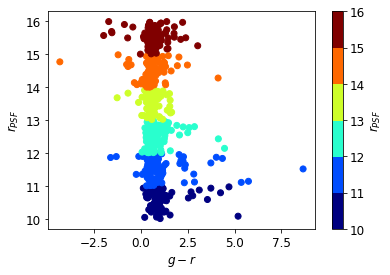

In [4]:
# define the colormap
cmap = plt.cm.jet

# define the bins and normalize
bounds = np.linspace(10, 16, 7)
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(t['gr'], t['psfMag_r'], marker='o', cmap=cmap, c=np.floor(t['psfmag_r']), norm=norm)
plt.xlabel('$g-r$')
plt.ylabel(r'$r_{PSF}$')
plt.colorbar(label='$r_{PSF}$')

In [5]:
m, gr = extract_mag_band(t, 10, 11)

In [6]:
def plot_histogram(data, binning_style, label, ax=None, xmin=10, xmax=17):
    """
    Convenience routine for plotting a histogram.
    """

    if ax is not None:
        ax = plt.axes(ax)

    counts, bins, patches = hist(data, bins=binning_style, ax=ax,
                                 color='k', histtype='step', normed=True)
    ax.text(0.95, 0.93, '{0:s}:\n{1:d} bins'.format(label, len(counts)),
            transform=ax.transAxes, ha='right', va='top')

    # Turn off y-axis labeling.
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(xmin, xmax)

    return ax

## Colour distributions - simple histogram

The first we want to do is to make a simple histogram of the g-r colour. The point here is to contrast different approaches. The classical approach is to use an empirical rule. This is shown in the first two panels. The first uses Scott's rule which sets the bin size to be 

$$h_{\text{Scott}} = \frac{3.5\sigma}{N^{1/3}} $$

where $N$ is the number of data points and $\sigma$ is the sample standard deviation. Since there are outliers here the standard deviation is biased and the bins get to be set too large. A more robust rule of thumb is the Freedman-Diaconis rule

$$h_{\text{F-D}} = \frac{2.7\sigma_G}{N^{1/3}} $$,

where $\sigma_G$ is the standard deviation inferred from the inter-quartile range of the data, so resistent to outliers. $N$ is the number of points as before. This seems better but has very small bins in the outlier parts of the data.

The third panel uses Knuth's histogram rules. The bin size here is based on a Bayesian analysis that attempts to find the bin size leading to the best agreement between the histogram and the true underlying distribution. For reference, the equation that needs to be maximised for the number of bins $M$, is

$$p(M|{x_i}) = N \ln  M + \ln \left[\Gamma\left(\frac{M}{2}\right)\right]  - 
  M\ln \left[\Gamma\left(\frac{1}{2}\right)\right] - \ln \left[\Gamma\left(N+\frac{M}{2}\right) \right] + \sum_{k=1}^M \ln \left[\Gamma\left(n_k + \frac{1}{2}\right)\right] $$
  
  where $\Gamma$ is the gamma function, $N$ is the number of points, and $n_k$ is the number of data points in bin $k$. There is no need to memorise this equation...
  
The final panel uses Bayesian Blocks, a concept introduced by Scargle and collaborators, see for instance [Scargle et al (2012)](http://adsabs.harvard.edu/abs/2013ApJ...764..167S) for details. The main use of this is arguably for time-series analysis but it also provides a way to divide up the data optimally (in a quantifiable way) with variable sized bins. There are many subtleties with this but it can be a good choice in general.
  
These rules are implemented in `astropy`'s hist function and also in the `astroml.plotting.hist` function that we use here. To choose Knuth's rule, you pass `bins='knuth'` to the routine for instance. The coding for the astroML version is described [in this blog post](https://jakevdp.github.io/blog/2012/09/12/dynamic-programming-in-python/) by Jake VanderPlas.

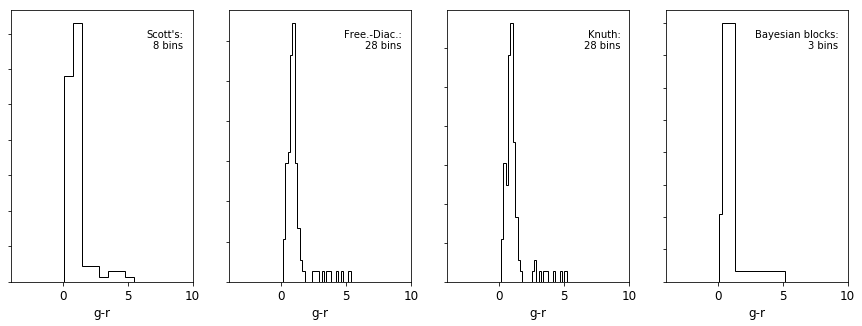

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
styles = ['scotts', 'freedman', 'knuth', 'blocks']
titles = ["Scott's", 'Free.-Diac.', 'Knuth', 'Bayesian blocks']
for i in range(len(styles)):
    axis = plot_histogram(gr, styles[i], titles[i], ax=ax[i], xmin=-4, xmax=10)
    ax[i].set_xlabel('g-r')

## Multi-modal distributions

Next, let us try this on a complex theoretical distribution. I will follow the blog post linked above to use a set of theoretical distributions with wings.

In [8]:
import scipy.stats as ss
np.random.seed(0)
x = np.concatenate([ss.cauchy(-5, 1.8).rvs(500),
                    ss.cauchy(-4, 1.2).rvs(2000),
                    ss.cauchy(-1.5, 0.4).rvs(500),
                    ss.cauchy(2, 0.8).rvs(1000),
                    ss.cauchy(4, 1.5).rvs(500)])
x = x[(x > -15) & (x < 15)]

# I also want the true distribution for overplotting
xvals = np.linspace(-15, 15, 1000)
yvals = 500*ss.cauchy(-5, 1.8).pdf(xvals)+2000*ss.cauchy(-4, 1.2).pdf(xvals)+ 500*ss.cauchy(-1.5, 0.4).pdf(xvals) + 1000*ss.cauchy(2, 0.8).pdf(xvals)+500*ss.cauchy(4, 1.5).pdf(xvals)

# Since I plot normalised histograms I need to normalise the true distribution as well.
yvals = yvals/np.trapz(yvals, xvals)

The theoretical curves created, let us plot the histograms using the various settings to compare.

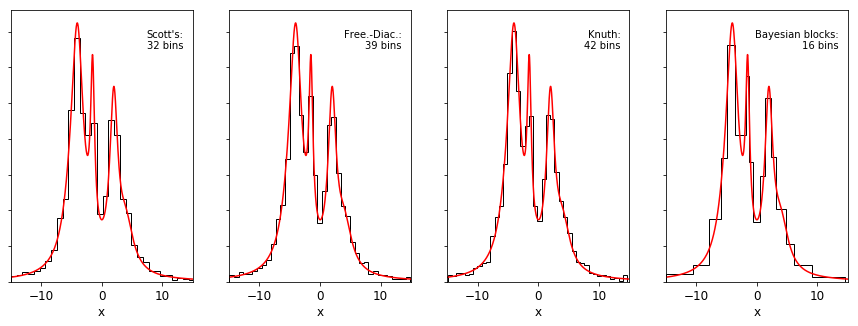

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
styles = ['scotts', 'freedman', 'knuth', 'blocks']
titles = ["Scott's", 'Free.-Diac.', 'Knuth', 'Bayesian blocks']
for i in range(len(styles)):

    axis = plot_histogram(x, styles[i], titles[i], ax=ax[i], xmin=-15, xmax=15)
    ax[i].plot(xvals, yvals, 'r')
    ax[i].set_xlabel('x')

No enormous difference is found but you can see that the variable bin size allows the Bayesian blocks to recover the spikiest parts of the distribution better than the other options.

Let us now turn to a practical application bimodal distribution, constructed by joining the 10-11 and 12-13 magnitude distributions together

In [10]:
m10, gr10 = extract_mag_band(t, 10, 11)
m12, gr12 = extract_mag_band(t, 12, 13)
mag_both = np.concatenate((m10, m12))
gr_both = np.concatenate((gr10, gr12))

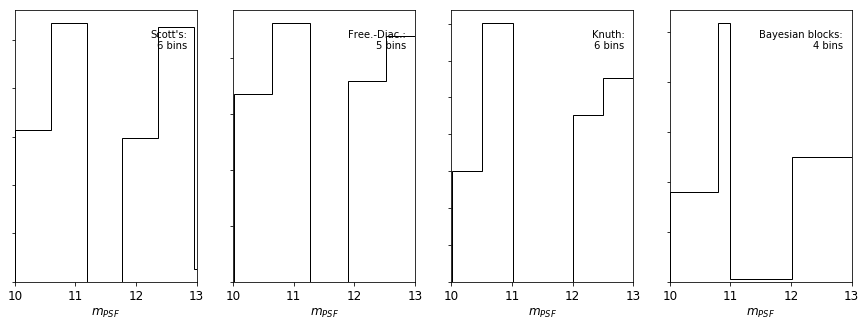

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
styles = ['scotts', 'freedman', 'knuth', 'blocks']
titles = ["Scott's", 'Free.-Diac.', 'Knuth', 'Bayesian blocks']
for i in range(len(styles)):
    axis = plot_histogram(mag_both, styles[i], titles[i], ax=ax[i], xmin=10, xmax=13)
    ax[i].set_xlabel('$m_{PSF}$')

When I look at at this, what strikes me is that none of the choices are particular good. This is a case where I probably would have used a fixed bin size based on trial and error. But another possibility is of course to use other approaches.

# Playing with non-parametric density estimators

Now, I will generalise from the use of a box function to create a density estimate (histograms) to using a general function. I will start with Kernel density estimators

## Kernel density estimation

First, let us illustrate four commonly used kernels

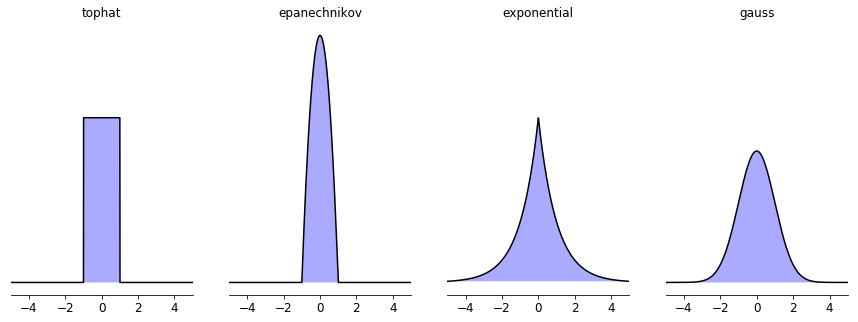

In [12]:
# Show the kernels over -5 to 5
from matplotlib.lines import Line2D
x = np.linspace(-5, 5, 5000)
dx = x[1] - x[0]

kernels = {'gauss': (1. / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x ** 2),
           'exponential': 0.5 * np.exp(-abs(x)),
           'tophat': 0.5*np.ones_like(x)*(abs(x) < 1),
           'epanechnikov': 0.75*(1-x*x)*(abs(x) < 1)}
           

fig, axes = plt.subplots(1, 4, sharey=True, frameon=False)
fig.set_size_inches(15, 5)
fig.set_frameon(False)
# fig.figsize(5,15)
for (k, ax) in zip(kernels, axes):

    ax.plot(x, kernels[k], '-', c='black')
    ax.fill(x, kernels[k], '-k', fc='#AAAAFF')

    # This turns off the tick marks on the y-axis and removes the bars on the left, 
    # right and top. 
    ax.get_yaxis().set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()

    ax.set_xlim(-5, 5)    
    
    ax.set_title(k)



A key thing you can see in this figure is that the two kernels on the left both are limited to a finite range in x (they have finite support), while the exponential and Gaussian kernels extend to infinity (have infinite support). This can have implementation consequences - in some cases a kernel with finite support can be used to speed up calculations. The Epanechnikov kernel in addition has the nice theoretical property that it minimises variance (is least sensitive to a swap of data).

## Simple KDE in practice



In [13]:
# I will use the KernelDensity class from Scikit-learn rather than the astroML implementation
# because in the documentation of that function they recommend Scikit-learn.
from sklearn.neighbors import KernelDensity

from astroML.datasets import fetch_great_wall
from matplotlib.colors import LogNorm

In [14]:
#------------------------------------------------------------
# Fetch the great wall data
X = fetch_great_wall()

In [15]:
# Run the fit

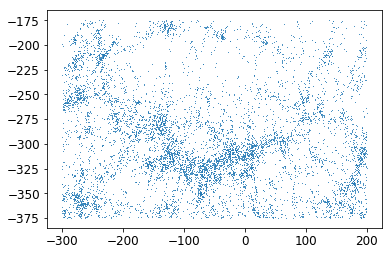

In [16]:
# Plot the raw data.
plt.scatter(X[:, 1], X[:, 0], s=1, lw=0)

In [17]:
# Create  the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)

In [18]:
xgrid = np.linspace(xmin, xmax, Nx)
ygrid = np.linspace(ymin, ymax, Ny)
mesh = np.meshgrid(xgrid, ygrid)

In [19]:
tmp = map(np.ravel, mesh)
Xgrid = np.vstack(tmp).T

### Gaussian kernel

### Top-hat

### Exponential kernel

### Epanechnikov kernel

### K-nearest Neighbours

Here an example of how to use K-nearest Neighbours to estimate the density

In [28]:
from astroML.density_estimation import KNeighborsDensity

In [29]:
knd = KNeighborsDensity("bayesian", 10)
knd.fit(X)
dens = knd.eval(Xgrid)
dens_knd = dens.reshape((Ny, Nx))

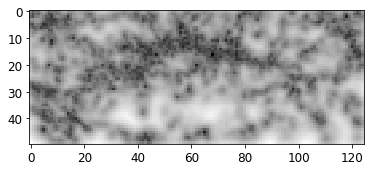

In [30]:
plt.imshow(dens_knd.T, cmap=plt.cm.binary, norm=LogNorm())

## Finding the best band-width using cross-validation

I will start with leave-one-out CV. The idea here is that the kernel we estimate defines a likelihood distribution. So if for a given bandwidth, $h_i$, we estimate the density excluding one point, we can then check how this distribution works on that point - if the bandwidth is well-selected the point should be relatively likely, if it is not then we should see a big jump in likelihood. Of course to do this in practice we also need to sum over the points left out. The final score is then given as

$$\text{CV}_1 = \frac{1}{N} \sum_{i=1}^N \ln f_{h, -i}(x_i) $$

where $f_{h,-i}$ is the kernel density estimate leaving one point out.

First we need to create some random data. I will use a sample of Gaussians.

In [32]:
np.random.seed(1)
N = 150
i1 = np.int(0.2*N)
i2 = np.int(0.6*N)
X = np.concatenate((np.random.normal(0, 1, i1),
                    np.random.normal(5, 0.7, i2),
                   np.random.normal(3, 0.2, i1)))[:, np.newaxis]
np.random.shuffle(X)

Nb = 2000
Xbig = np.concatenate((np.random.normal(0, 1, i1),
                    np.random.normal(5, 0.7, i2),
                   np.random.normal(3, 0.2, i1)))[:, np.newaxis]

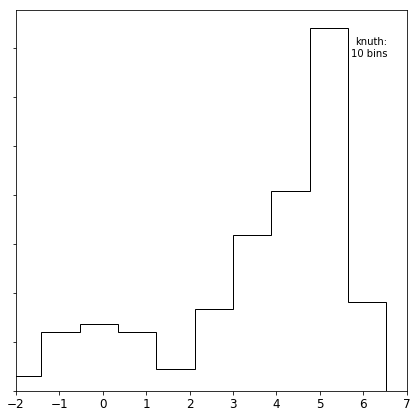

In [33]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plot_histogram(X[:,0], 10, 'knuth', ax=ax, xmin=-2, xmax=7)

In [34]:
len(X)

150

In [35]:
from sklearn.cross_validation import KFold

def cv1(x, bws, model='gaussian', plot=False, n_folds=10):
    """
    This calculates the leave-one-out cross validation. If you set 
    plot to True, then it will show a big grid of the test and training
    samples with the KDE chosen at each step. You might need to modify the 
    code if you want a nicer layout :)
    """

    # Get the number of bandwidths to check and the number of objects
    N_bw = len(bws)
    N = len(x)
    cv_1 = np.zeros(N_bw)
    
    # If plotting is requested, set up the plot region
    if plot:
        fig, axes = plt.subplots(N_bw, np.ceil(N/n_folds), figsize=(15, 8))
        xplot = np.linspace(-3, 8, 1000)

    # Loop over each band-width and calculate the probability of the 
    # test set for this band-width
    for i, bw in enumerate(bws):
    
        # I will do N-fold CV here. This divides X into N_folds
        kf = KFold(N, n_folds=n_folds)

        # Initiate - lnP will contain the log likelihood of the test sets
        # and i_k is a counter for the folds that is used for plotting and
        # nothing else..
        lnP = 0.0
        i_k = 0
                                 
        # Loop over each fold
        for train, test in kf:
            x_train = x[train, :]
            x_test = x[test, :]
            
            # Create the kernel density model for this bandwidth and fit
            # to the training set.
            kde = KernelDensity(kernel=model, bandwidth=bw).fit(x_train)
                                 
            # score evaluates the log likelihood of a dataset given the fitted KDE.
            log_prob = kde.score(x_test)
            
            if plot:
                # Show the tries
                ax = axes[i][i_k]

                # Note that the test sample is hard to see here.
                hist(x_train, bins=10, ax=ax, color='red')
                hist(x_test, bins=10, ax=ax, color='blue')
                ax.plot(xplot, np.exp(kde.score_samples(xplot[:, np.newaxis])))
                i_k += 1
            

            lnP += log_prob
            
        # Calculate the average likelihood          
        cv_1[i] = lnP/N
        
    return cv_1


/Users/jarle/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


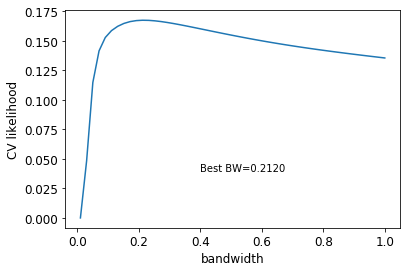

In [36]:
bws = np.linspace(0.01, 1, 50)
cv = cv1(X, bws)
plt.plot(bws, np.exp(cv))
plt.xlabel('bandwidth')
plt.ylabel('CV likelihood')
plt.text(0.4, 0.04, 'Best BW={0:.4f}'.format(bws[np.argmax(cv)]))

This gives us an estimate of the best kernel band-width of 0.212. That is a useful start. To get a better solution you could now interpolate the data above and find the maximum of that

In [37]:
bw_big = np.linspace(0.1, 0.3, 1000)
cv_big = np.interp(bw_big, bws, cv)
print "The linearly interpolated maximum is={0:.4f}".format(bw_big[np.argmax(cv_big)])

The linearly interpolated maximum is=0.2121


Now, that used linear interpolation - it might be better to use a higher order interpolation - we do this using `scipy.interpolate`. Here I use a third order because a second order gives very odd results.

In [38]:
from scipy import interpolate
f = interpolate.interp1d(bws, cv, kind=3)
cv_big2 = f(bw_big)
print "The quadratically interpolated maximum is={0:.4f}".format(bw_big[np.argmax(cv_big2)])

The quadratically interpolated maximum is=0.2161


You might worry that this is slightly different - the reason is what you see below - the peak is not very well defined. Do not expect that there always is a well-defined solution 

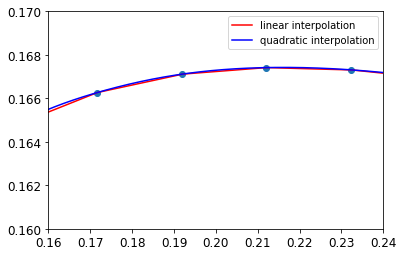

In [39]:
plt.plot(bws, np.exp(cv), 'o')
plt.plot(bw_big, np.exp(cv_big), 'r', label='linear interpolation')
plt.plot(bw_big, np.exp(cv_big2), 'b', label='quadratic interpolation')
plt.xlim(0.16, 0.24)
plt.ylim(0.16, 0.17)
plt.legend()

## Cross-validation using GridSearchCV

A convenient alternative to manual cross-validation as outlined above, is to use the `GridSearchCV` function in `sklearn.model_selection`. This allows you to specify the parameters of the function (here `KernelDensity`) that you want to vary. Since we want to vary the bandwidth, the dictionary `params` before has one key: `bandwidth` which points to the bandwidths we want to search over.

You can specify the cross-validation either explicitly (by creating a `KFold` object), or indirectly as below where I just specify the number of folds as an integer (the default is 3).

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
params = {'bandwidth': bws}

In [53]:
# cv=5 indicates 5-fold cross-validation
grid = GridSearchCV(KernelDensity(), params, cv=5)
grid.fit(X, y=None, groups=None)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

best bandwidth: 0.212040816327


In [ ]:
kde = grid.best_estimator_

In [ ]:
xplot = np.linspace(-3, 8, 1000)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plot_histogram(X[:,0], 10, '', ax=ax, xmin=-3, xmax=8)
ax.plot(xplot, np.exp(kde.score_samples(xplot[:, np.newaxis])))

In [ ]:
from astroML.datasets import fetch_great_wall

X = fetch_great_wall()

In [ ]:
bws2 = np.linspace(0.5, 10, 50)

## Gaussian mixture modeling

Next, let us try Gaussian mixture modeling.

In [ ]:
from sklearn.mixture import GMM

In [ ]:
model = GMM(3)
model.fit(X)

In [ ]:
model.means_